In [ ]:
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import torch

In [ ]:
# Discretize Space
L = 1
N = 300
x = np.linspace(0, L, N)
dx = x[1] - x[0]

# Discretize Time
T = 30
M = 6000
t = np.linspace(0, T, M)
dt = t[1] - t[0]

# Parameters
c = 0.5
r_W = 0.5
r_E = 0.5
gamma = 0.2
alpha = 0.9

# Thermocline
eta = 1.5 + (0.5*np.tanh(7.5*(x - L/2)))

In [ ]:
# Set up initial conditions

K = np.zeros((M, N))    # time, space
R = np.zeros((M, N))
T = np.zeros((M, N))

K[0,:] = 0.25 * np.linspace(0.5, 0.25 ,N)
R[0,0] = (1/r_W) * K[0,0]
R[0,N-1] = r_E * K[0,N-1]
R[0,:] = np.linspace(R[0,0] , R[0,N-1] ,N)

T[0,:] = 0.25 * np.linspace(0.75, -0.75 ,N)

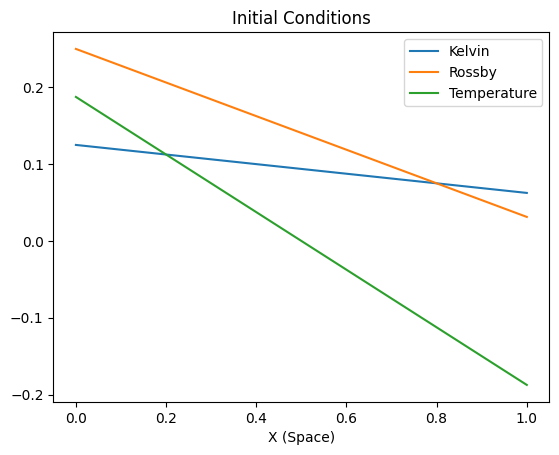

In [ ]:
plt.plot(x, K[0, :], label="Kelvin")
plt.plot(x, R[0, :], label="Rossby")
plt.plot(x, T[0, :], label="Temperature")
plt.title("Initial Conditions")
plt.xlabel("X (Space)")
plt.legend()

Text(0.5, 0, 'X (Space)')

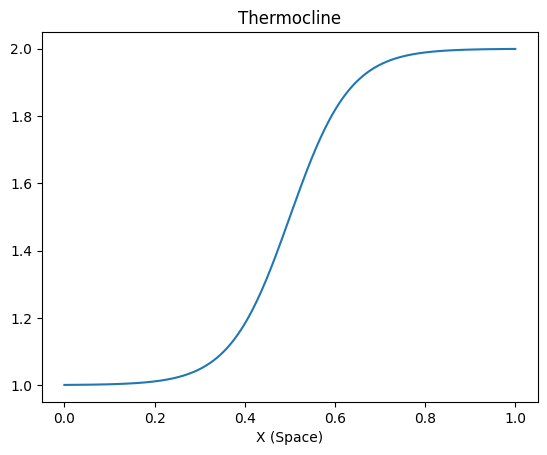

In [ ]:
plt.plot(x, eta)
plt.title("Thermocline")
plt.xlabel("X (Space)")

# Zonal Wind Profile

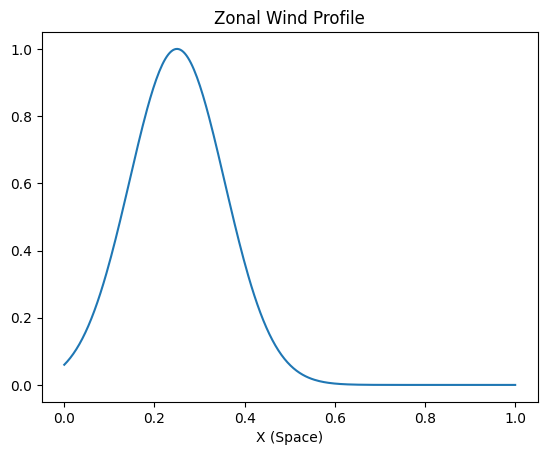

In [ ]:
zonal_wind_profile = np.exp(-45 * (x - L/4)**2)

plt.plot(x, zonal_wind_profile)
plt.title("Zonal Wind Profile")
plt.xlabel("X (Space)")
plt.show()

# Orstein Uhlenbeck Process

In [ ]:
theta = 0.7
mu = 1.5
sigma = 0.3
delta = 0.005

dt = t[1] - t[0]
X = np.zeros(M)
W = np.random.normal(loc = 0, scale = 1, size = M)

In [ ]:
for i in range(M - 1):
    X[i + 1] = X[i] + theta * (mu - X[i]) * dt + sigma * W[i] * np.sqrt(dt)

Text(0.5, 0, 't (Time)')

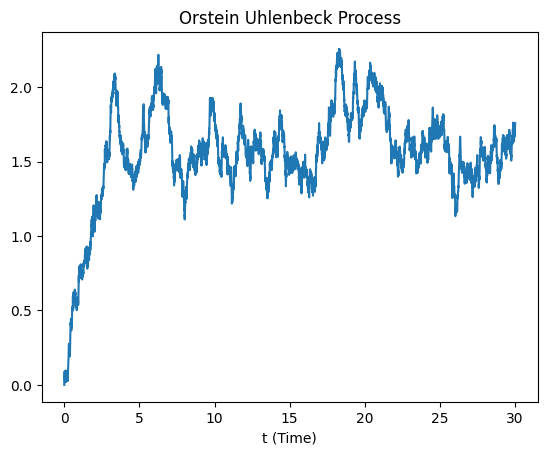

In [ ]:
plt.plot(t, X)
plt.title("Orstein Uhlenbeck Process")
plt.xlabel("t (Time)")

# Time-stepping loop

In [ ]:
for i in range(M - 1):
    K[i+1, 0] = K[i,0] - delta * K[i,0] - c * (dt/dx) * (K[i, 0] - r_W*R[i, 0]) + gamma * (T[i, 0] + zonal_wind_profile[0] * X[i]) * dt
    for j in range(1, N):
        K[i+1, j] = K[i,j] - delta * K[i,j] - c * (dt/dx) * (K[i,j] - K[i, j-1]) + gamma * (T[i, j] + zonal_wind_profile[j] * X[i]) * dt
    for j in range(0, N - 1):
        R[i+1, j] = R[i,j] - delta * R[i,j]+ (c/3) * (dt/dx) * (R[i, j+1] - R[i, j]) + gamma * (T[i, j] + zonal_wind_profile[j] * X[i]) * dt
    R[i+1, N - 1] = R[i,N - 1] - delta*R[i,N - 1]+ (c/3) * (dt/dx) * (r_E*K[i, N - 1] - R[i, N - 1]) + gamma * (T[i, N - 1] + zonal_wind_profile[N-1] * X[i]) * dt
    for j in range(N):
        T[i+1, j] = T[i, j] + dt * (-alpha * T[i, j] + c * eta[j] * (K[i, j] + R[i, j]))

# Plot 3D Models

Text(0.5, 0, 'T')

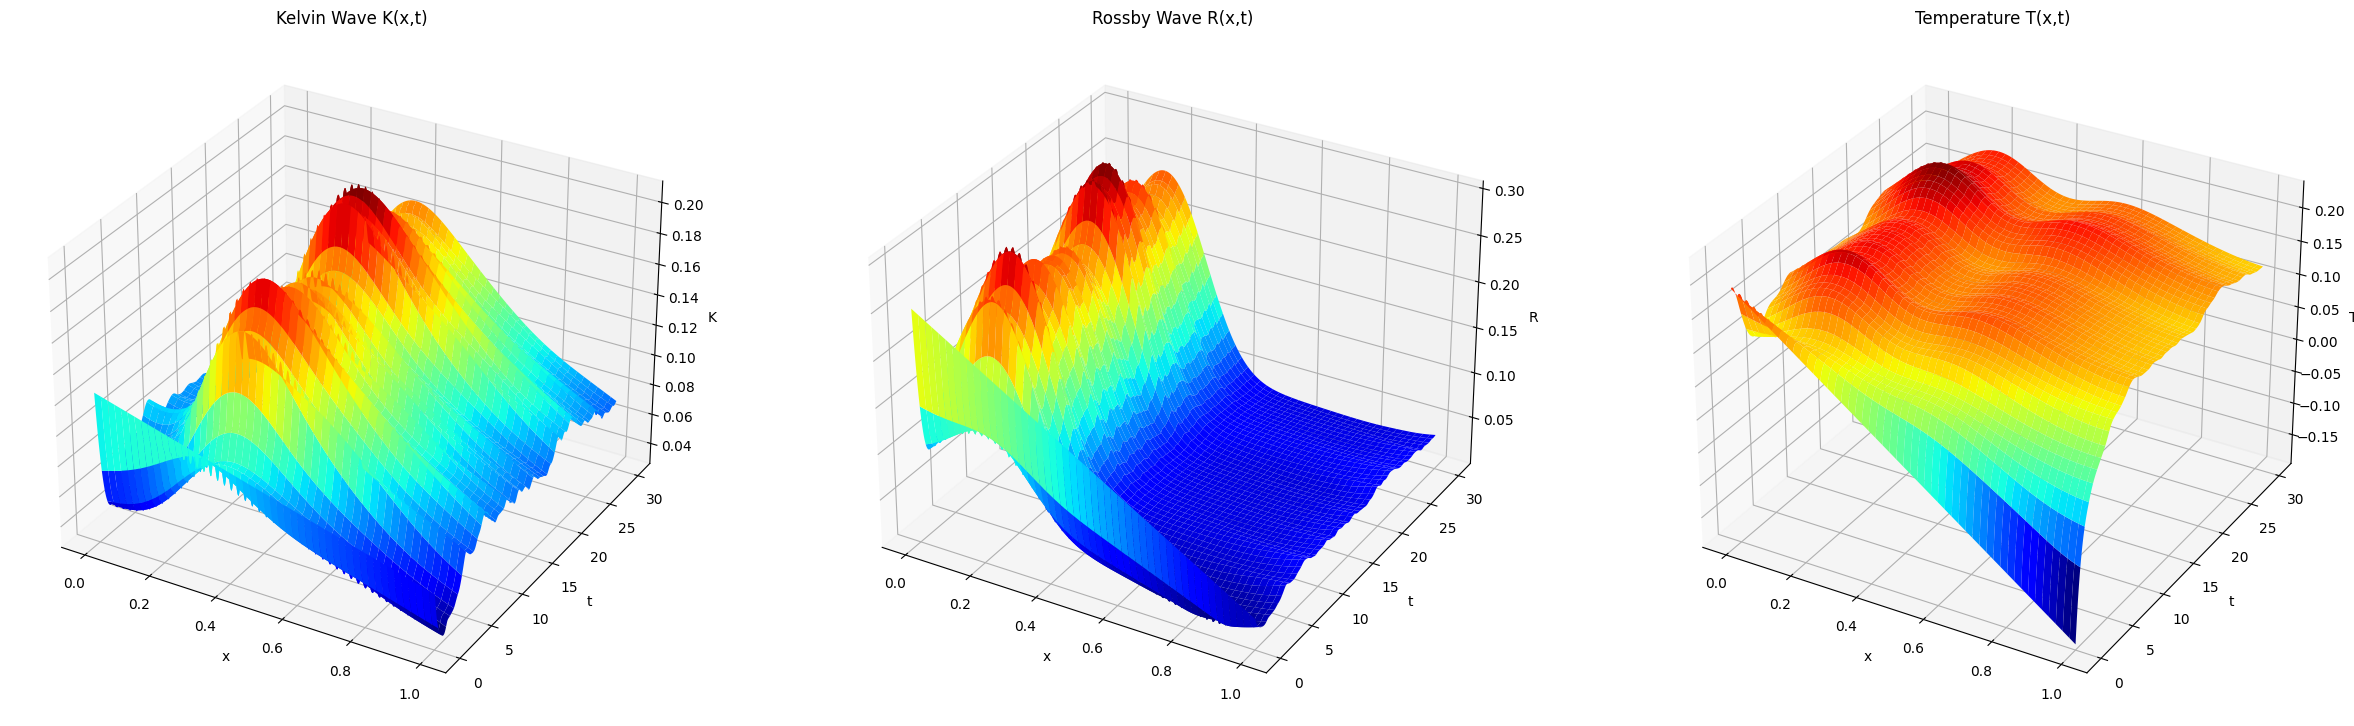

In [ ]:
fig = plt.figure(figsize=(30, 25))

x, y = np.meshgrid(x, t)

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot_surface(x, y, K, cmap='jet')
ax1.set_title('Kelvin Wave K(x,t)')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('K')

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot_surface(x, y, R, cmap='jet')
ax2.set_title('Rossby Wave R(x,t)')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('R')

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.plot_surface(x, y, T, cmap='jet')
ax3.set_title('Temperature T(x,t)')
ax3.set_xlabel('x')
ax3.set_ylabel('t')
ax3.set_zlabel('T')

# Approximate using Singular Value Decomposition

In [ ]:
U, S, V = linalg.svd(T)

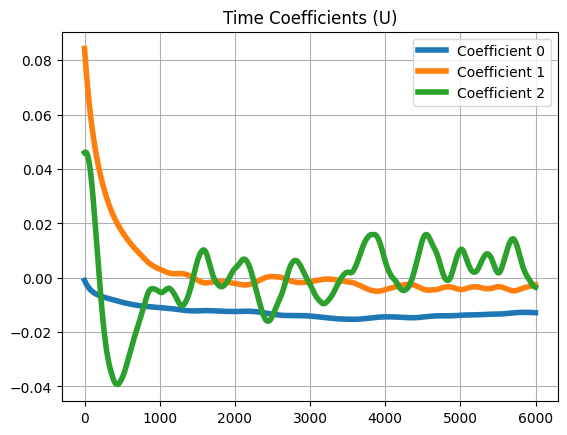

In [ ]:
for k in range(3):
  plt.plot(U[:, k], linewidth=4, label=f'Coefficient {k}')
plt.title("Time Coefficients (U)")
plt.legend()
plt.grid()

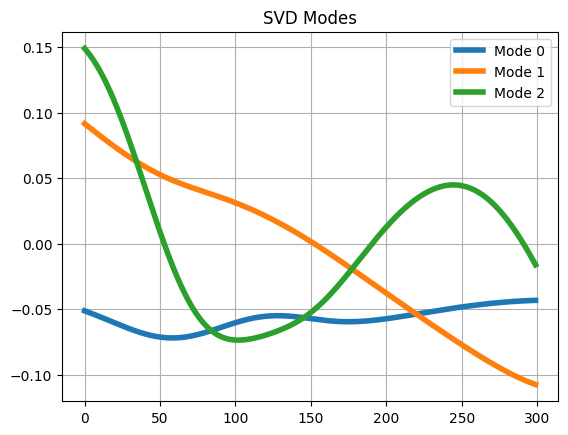

In [ ]:
for k in range(3):
  plt.plot(V.T[:, k], linewidth=4, label=f'Mode {k}')
plt.title("SVD Modes")
plt.legend()
plt.grid()

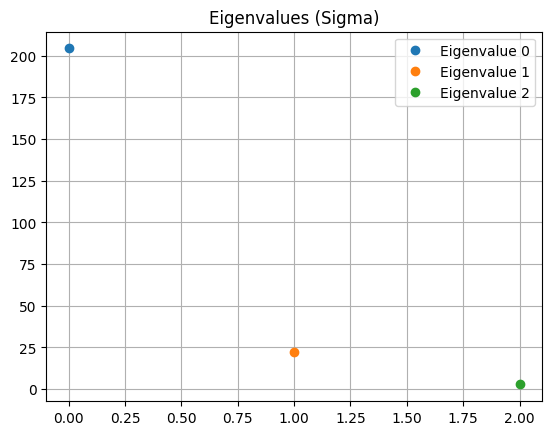

In [ ]:
for k in range(3):
  plt.plot(k, S[k],'o', label=f'Eigenvalue {k}')
plt.title("Eigenvalues (Sigma)")
plt.legend()
plt.grid()

# Plot approximation errors

In [ ]:
error = np.zeros(10)

for i in range(1,11):
  T_approx = np.matmul(np.matmul(U[:, :i],np.diag(S)[:i,:i]), V[:i, :])
  error[i - 1] = linalg.norm(T - T_approx)

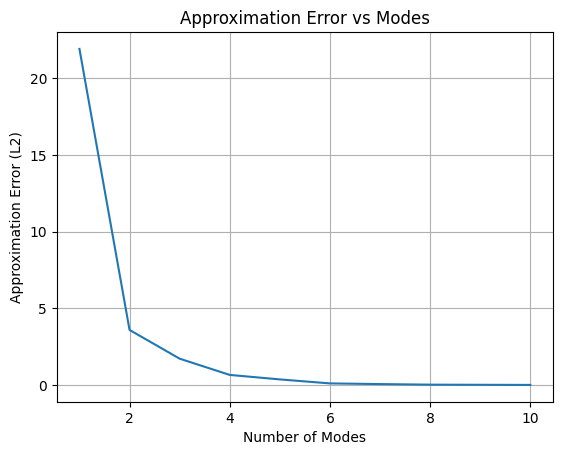

In [ ]:
plt.plot(np.arange(1, 11, 1), error)
plt.title("Approximation Error vs Modes")
plt.xlabel('Number of Modes')
plt.ylabel('Approximation Error (L2)')
plt.grid()